In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import emcee
import corner

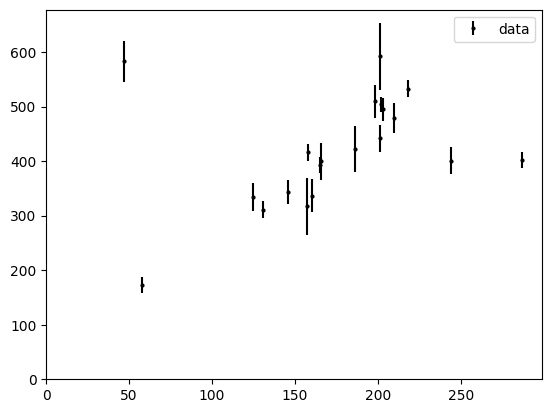

In [21]:
# Load data table
DataTable = np.loadtxt('Table1.csv',delimiter=',', usecols=range(1,6))
x = DataTable[:,0]
y = DataTable[:,1]
err = DataTable[:,2]
# Plot data
plt.errorbar(x, y, err, ls='none', fmt='o', ms=2, label='data', color='black')
plt.xlim(0,)
plt.ylim(0,)
plt.legend()
plt.show()

In [55]:
2*np.log(0.1)

-4.605170185988091

In [56]:
# Define priors, likelihood, and posterior
def log_likelihood(theta, x, y, yerr):
    m, b, Pb, Yb, log_Vb = theta
    Vb = np.exp(log_Vb)
    model = m * x + b
    sigma2 = yerr**2
    p_fg = (1 / np.sqrt(2 * np.pi * sigma2)) * np.exp( -0.5 * (y - model)**2 / sigma2 )
    p_bg = ( 1 / np.sqrt( 2 * np.pi * (Vb + sigma2) ) ) * np.exp( -0.5 * (y - Yb)**2 / ( Vb + sigma2 ) )
    return np.sum( np.log( (1 - Pb) * p_fg + Pb * p_bg ) )

def log_prior(theta):
    m, b, Pb, Yb, log_Vb = theta
    if -0.5 < m < 10 and -10 < b < 600 and 0.0 < Pb < 1.0 and 100 < Yb < 600 and -5 < log_Vb < 12:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [57]:
nwalkers, ndim = 32, 5
start = np.repeat( np.array([[2.24, 34, 0.5, 400, 0]]), nwalkers, axis=0) + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(x, y, err)
)
sampler.run_mcmc(start, 10000, progress=True);

100%|██████████| 10000/10000 [00:05<00:00, 1698.71it/s]


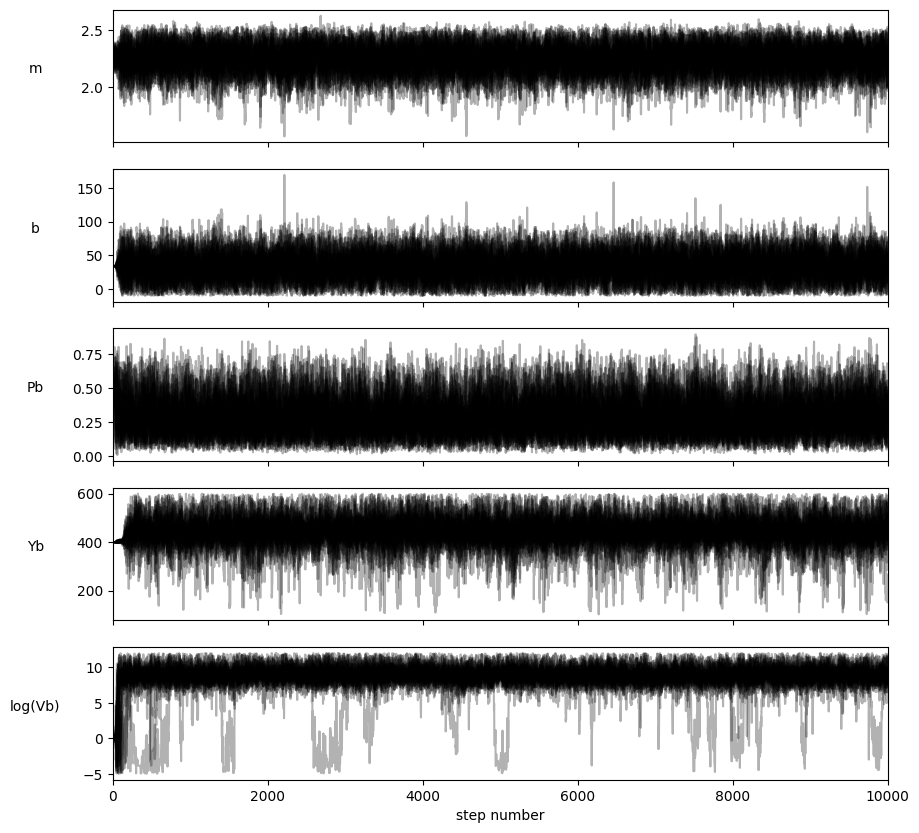

In [58]:
# Time-series of parameters
fig, axes = plt.subplots(5, figsize=(10,10), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "Pb", "Yb", "log(Vb)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

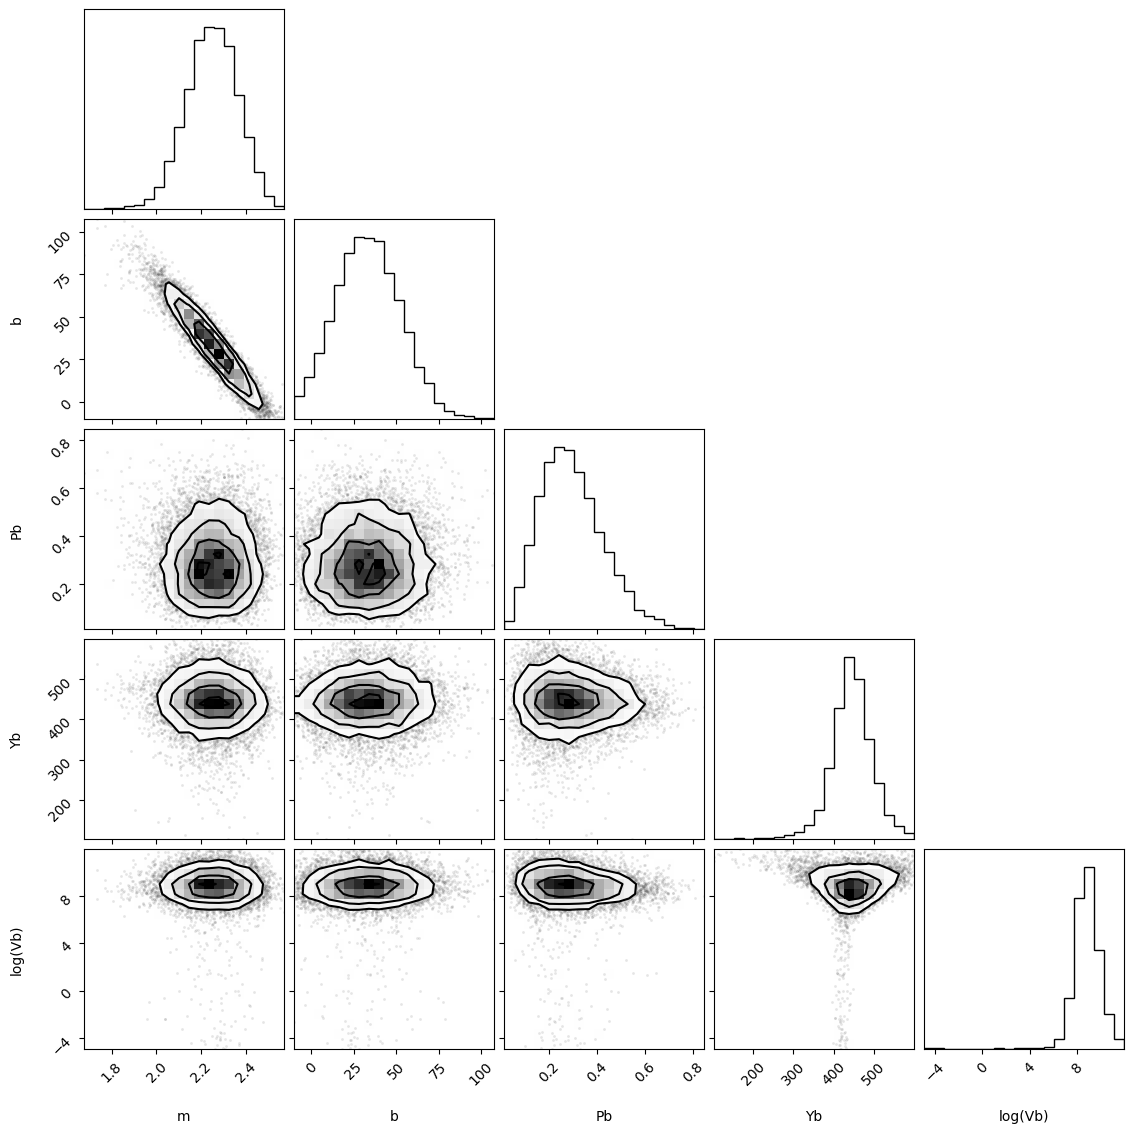

In [60]:
flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)

fig = corner.corner(
    flat_samples, labels=labels
);

m (MAP): 2.231
b (MAP): 34.699


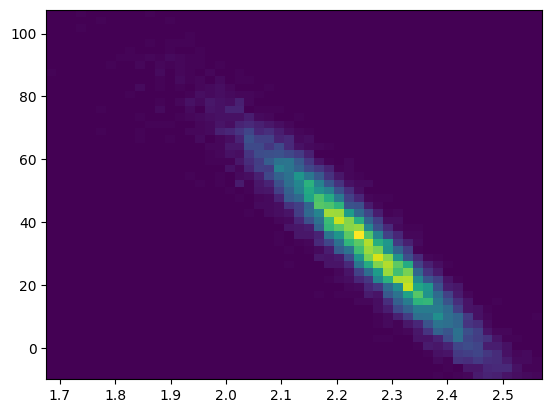

In [133]:
# MAP result
n, bins_m, bins_b, patches = plt.hist2d(flat_samples[:,0], flat_samples[:,1], bins=50);
index_mode = np.where(n==n.max())
m_MAP = bins_m[index_mode[0][0]]
b_MAP = bins_b[index_mode[1][0]]
print('m (MAP): {0:.3f}'.format(m_MAP))
print('b (MAP): {0:.3f}'.format(b_MAP))

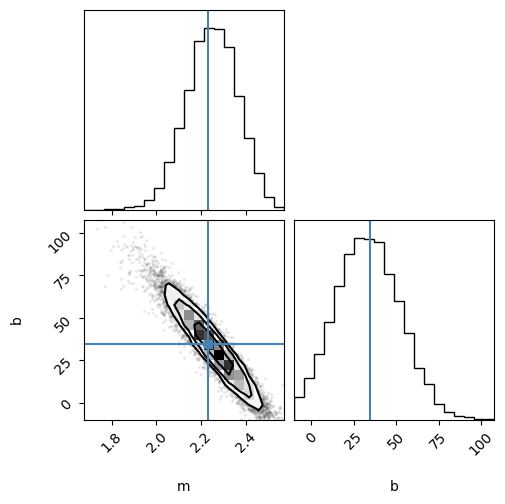

In [131]:
# Marginalized corner plot
fig = corner.corner(
    flat_samples[:,0:2], labels=labels[0:2], truths=[m_MAP, b_MAP]
)


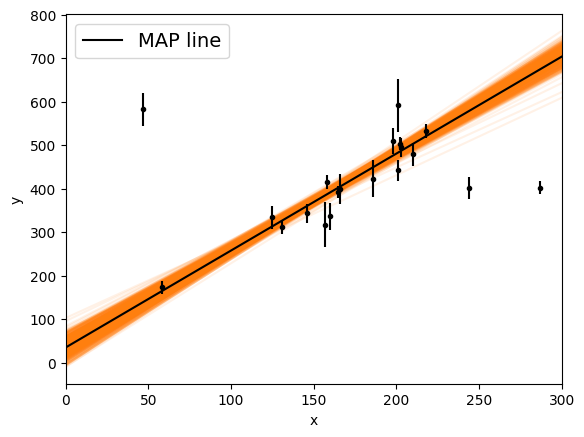

In [136]:
inds = np.random.randint(len(flat_samples), size=500)
x0 = np.linspace(0, 300, 1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, sample[0] * x0 + sample[1], "C1", alpha=0.1)
plt.plot(x0, m_MAP * x0 + b_MAP, "k", label='MAP line')
plt.errorbar(x, y, err, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlim(0, 300)
plt.xlabel("x")
plt.ylabel("y");

In [137]:
# 85th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [138]:
# 95th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [6, 50, 94])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>